#  Model assessment: LOO-CV for factory data with Stan

In this exercise, the aim is to assess the predictive performance of the pooled, separate and
hierarchical Gaussian models developed for the factory dataset. The data provided contain
quality control measurements from 6 machines in a factory and more specifically only 5
measurements were done for each machine.

## To recap:
Three different models were used for modelling the data:

• Separate model: each of the i th machine (i = 1, ..., 6) is modelled with its own model, that is:
\begin{equation}
y_i ∼ N(μ_i,σ_i)
\end{equation}
where $μ_i$ and $σ_i$ are the mean and standard deviation of the distribution associated with the ith machine and $y_i$ represents the measurements of the i th machine.


• Pooled model: all the measurements are considered together, without making any difference between the machines. This means that the following model is considered:
\begin{equation}
y ∼ N(μ,σ)
\end{equation}
where y is a quality measurement from any machine, and μ and σ are the parameters characterizing the normal distribution.


• Hierarchical model: in this case, the following model is considered:
\begin{equation}
y_i ∼ N(μ_i,σ)
\end{equation}
and at the same time is assumed that the mean values μ i are drawn from a normal distribution $N(μ_0 , σ_0)$.


## Some theory.

All the three models were implemented in Stan with default settings (i.e. 4 chains, 2000 iterations of which 1000 of warm-up and uniform priors). 

The predictive performance of the three models were evaluated with the Pareto smoothed importance sampling (PSIS) leave-one-out (LOO) cross-validation. The PSIS-LOO is a particularly new implementation  of the LOO scheme. If n observation are available, we fit n models to the data by leaving one of the data points out at each time. This data point is then used to estimate how well the model is able in predicting it. The predictive accuracy for a fitted model is called log pointwise predictive density (lppd) and it is evaluated as:

\begin{equation}
\text{lppd} = \sum\limits_{i=1}^n log\bigg(\frac{1}{S}\sum\limits_{s=1}^S p(y_i|\theta^s)\bigg)
\end{equation}

where S is the number of simulations drawn from the posterior probability and $y_i$ are the observations.

In case of PSIS-LOO cross-validation, the estimate log pointwise predictive density is.

\begin{equation}
\text{lppd}_{llo-cv} = \sum\limits_{i=1}^n log\bigg(\frac{\sum_{s=1}^S w_i^s p(y_i|\theta^s)}{\sum_{s=1}^S w_i^s}\bigg)
\end{equation}

Now the equation $p_{loo-cv} = \text{lppd}-\text{lppd}_{loo-cv}$ can be used to estimate the complexity of the used models 

In the PSIS method, also the estimated shape k̂ of the generalized Pareto distribution can be used to assess the reliability of the estimate. High estimates of k̂ (generally > 1) indicate that the full posterior is not a good importance sampling approximation to the desired leave-one- out posterior, and thus the observation is surprising according to the model. In case of k̂ < 0.5, model is considered good and in case of 0.5 < k̂ < 1, attention should be paid, but generally up to 0.7 the models are good.

## Code base 

In [22]:
%matplotlib inline

import pystan
import numpy as np 
import matplotlib.pyplot as plt
import utilities_and_data.psis as util

### import data

In [16]:
data = np.fromfile('data/factory.txt',sep=' ',dtype='i')
# Create data dict
y = data.reshape((5,6)).T
y = y.reshape(30)
N = 5*6
x = np.repeat(np.arange(1,6),6).reshape((5,6)).T
x = x.reshape(30)
data_dic = {'N': N,
               'y': y,
               'x': x,
               'K': 6}

### The 3 models (results follows)

In [42]:
separate_mod = """
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; // data
}
parameters {
    vector[K] mu; // group means
    vector<lower=0>[K] sigma; // group stds
}
model {
    for (n in 1:N)
    y[n] ~ normal(mu[x[n]], sigma[x[n]]);
}
generated quantities {
    vector[N] log_lik;
    for (n in 1:N)
    log_lik[n] <- normal_log(y[n], mu[x[n]], sigma[x[n]]);
}
"""

pool_mod = """
data {
    int<lower=0> N; // number of data points
    vector[N] y; // data
}
parameters {
    real mu; // group means
    real<lower=0> sigma; // group stds
}
model {
    y ~ normal(mu, sigma);
}
generated quantities {
    vector[N] log_lik;
    for (n in 1:N)
    log_lik[n] <- normal_log(y[n], mu, sigma);
}
"""
hiera_mod = """
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; // data
}
parameters {
    real mu0; // prior mean
    real<lower=0> sigma0; // prior std
    vector[K] mu; // group means
    real<lower=0> sigma; // common std
}
model {
mu ~ normal(mu0, sigma0); // population prior with unknown parameters
for (n in 1:N)
y[n] ~ normal(mu[x[n]], sigma);
}
generated quantities {
vector[N] log_lik;
for (n in 1:N)
log_lik[n] <- normal_log(y[n], mu[x[n]], sigma);
}
"""

### Compile models

In [43]:
sm = pystan.StanModel(model_code=separate_mod)
pm = pystan.StanModel(model_code=pool_mod)
hm = pystan.StanModel(model_code=hiera_mod)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0d3f3e20c32947697081d8c80736215b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f36d56d5a1909cf65d4f4cbdac3df63a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f08e23439f974d7c6f27f8722027b828 NOW.


### Fit

In [44]:
sm_fit = sm.sampling(data=data_dic)
pm_fit = pm.sampling(data=data_dic)
hm_fit = hm.sampling(data=data_dic)

### Extract estimats

In [45]:
sm_est = sm_fit.extract(permuted=True)
pm_est = pm_fit.extract(permuted=True)
hm_est = hm_fit.extract(permuted=True)

### Run psis-loo

In [53]:
sm_loo, sm_loos, sm_ks = util.psisloo(sm_est['log_lik'])
pm_loo, pm_loos, pm_ks = util.psisloo(pm_est['log_lik'])
hm_loo, hm_loos, hm_ks = util.psisloo(hm_est['log_lik'])

## Results

### Plot $\hat k$ for alle models

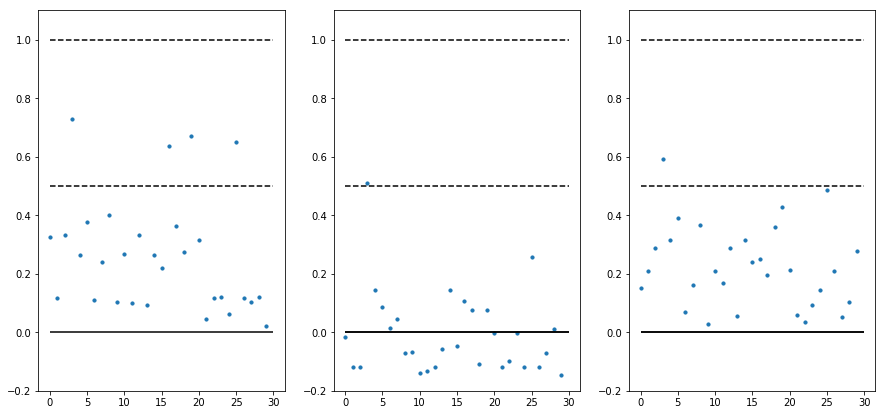

In [66]:
plt.figure(figsize=(15, 7))
plt.subplot(1,3,1)
plt.scatter(np.arange(len(sm_ks)),sm_ks,s=10)
plt.ylim(-0.2,1.1)
plt.hlines(0,0,30)
plt.hlines(0.5, 0, 30, linestyles='dashed')
plt.hlines(1, 0, 30, linestyles='dashed')

plt.subplot(1,3,2)
plt.scatter(np.arange(len(pm_ks)),pm_ks,s=10)
plt.ylim(-0.2,1.1)
plt.hlines(0,0,30)
plt.hlines(0,0,30)
plt.hlines(0.5, 0, 30, linestyles='dashed')
plt.hlines(1, 0, 30, linestyles='dashed')

plt.subplot(1,3,3)
plt.scatter(np.arange(len(hm_ks)),hm_ks,s=10)
plt.ylim(-0.2,1.1)
plt.hlines(0,0,30)
plt.hlines(0,0,30)
plt.hlines(0.5, 0, 30, linestyles='dashed')
plt.hlines(1, 0, 30, linestyles='dashed');

### Calculate p_eff

In [93]:
sm_lppd = np.sum(np.mean(sm_est['log_lik'], axis=0))
pm_lppd = np.sum(np.mean(pm_est['log_lik'], axis=0))
hm_lppd = np.sum(np.mean(hm_est['log_lik'], axis=0))

sm_p_eff = sm_lppd - sm_loo
pm_p_eff = pm_lppd - pm_loo
hm_p_eff = hm_lppd - hm_loo

print('The separet model: \n Effective number of parameters is ' + str(sm_p_eff) + '\n' +
      '-2lppd and -2lppd_loo_cv is respectivly [' + str(-2*sm_lppd) + ', ' + str(-2*sm_loo) + ']\n')
print('The pool model: \n Effective number of parameters is ' + str(pm_p_eff) + '\n' +
      '-2lppd and -2lppd_loo_cv is respectivly [' + str(-2*pm_lppd) + ', ' + str(-2*pm_loo) + ']\n')
print('The Hierarchical model: \n Effective number of parameters is ' + str(hm_p_eff) + '\n' +
      '-2lppd and -2lppd_loo_cv is respectivly [' + str(-2*hm_lppd) + ', ' + str(-2*hm_loo) + ']\n')

The separet model: 
 Effective number of parameters is 4.58301003409
-2lppd and -2lppd_loo_cv is respectivly [261.128404557, 270.294424625]

The pool model: 
 Effective number of parameters is 1.13909919484
-2lppd and -2lppd_loo_cv is respectivly [259.740975956, 262.019174346]

The Hierarchical model: 
 Effective number of parameters is 2.43904932044
-2lppd and -2lppd_loo_cv is respectivly [257.542473762, 262.420572403]



## Comments

The obtained parameters make it possible to compare the models. When the estimated shape parameter k̂ is considered, it is possible to observe that the separate model has 4 parameters in the range 0.5-1, the hierarchical 2 and the pooled model 1. This means that the pooled model seems to be the most reliable according to this parameter.

When the results in from the print out above are considered, it is possible to compare the models according to the parameters −2lppd and $−2lppd_{loo−cv}$ (lower values imply higher predictive accuracy). In this case, it is possible to observe that the hierarchical model has the highest predictive accuracy. Concerning the effective number of parameters, it can be seen that the pooled one has the lowest value, the hierarchical the middle and the separate model the highest. 

This was expected because in the separate model 12 parameters (6 means and 6 standard deviations) are estimated, in the pooled model 2 parameters (common mean and standard deviation) are estimated, and in the hierarchical model 9 parameters (6 means, common standard deviation and the two parameters originating the distribution of the mean) are estimated. The effective number of parameters gives an idea of the complexity of the model and as expected the pooled one has the lowest complexity. 

By taking into account all these aspects, it seems that the pooled model is the easiest and most reliable model, while the hierarchical one is the one with the highest predictive accuracy. Depending on the desired application one of these two can be chosen. On the other side, the separate model should be excluded because of its poor performances.